## Load the data

In [2]:
import numpy as np
import pandas as pd
# %pip install seaborn
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import sys
np.set_printoptions(threshold=500)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.3)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

teleplay_data = pd.read_csv('Teleplay.csv', sep=',')
rating_data = pd.read_csv('Rating.csv', sep=',')
#eliminate the data without rating
rating_data = rating_data[rating_data.rating > 0][['user_id','teleplay_id','rating']]

teleplay_rating = pd.merge(teleplay_data, rating_data,left_on="teleplay_id",right_on="teleplay_id")

teleplay_rating_mean = teleplay_rating.groupby(['teleplay_id'], as_index=False, sort=False).agg({'user_id':'count','rating_y' : 'mean'})\
.rename(columns={"user_id" : 'totalusers'}).sort_values(['totalusers'], ascending=False)

#preprocessing
# ratings_df = rating_data.pivot_table(index='user_id', columns='teleplay_id', values='rating')
ratings_df = rating_data.groupby(['user_id', 'teleplay_id']).rating.sum().unstack()

ratings = ratings_df.fillna(0).values

print(ratings_df.head())

teleplay_id  1      5      6      7      8      15     16     17     18     \
user_id                                                                      
1              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5              NaN    NaN    8.0    NaN    NaN    6.0    NaN    6.0    6.0   
7              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

teleplay_id  19     ...  34238  34239  34240  34252  34283  34324  34325  \
user_id             ...                                                    
1              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN 

## Preprocessing

In [3]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [4]:
train, val = train_test_split(ratings)
print(train)
print(val)


[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [10.  0. 10. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0. 10.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [5]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    print("this is prediction",prediction)
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

## Trained by SGD

In [6]:
class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
#         print("this is train_rmse",train_rmse)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
#         print("this is val_rmse",val_rmse)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()


this is prediction [3.46480901 3.45216195 3.69730221 ... 8.14587417 5.78240647 5.54271277]
this is prediction [5.45628625 5.26273244 5.25912172 ... 7.59008115 8.43043493 8.60371895]
this is prediction [3.73105857 3.71343025 3.95955147 ... 8.23730824 6.1258676  5.7276369 ]
this is prediction [6.55100819 6.09606853 6.18668508 ... 7.82609534 8.63605949 8.9423825 ]
this is prediction [3.95023005 3.92771621 4.18325108 ... 8.23668045 6.2910742  5.82329413]
this is prediction [7.05335634 6.49027932 6.60171469 ... 7.8523496  8.6453233  8.99573357]
this is prediction [4.14981141 4.1246002  4.39035633 ... 8.22792687 6.40004457 5.89100585]
this is prediction [7.30809211 6.69012755 6.80292835 ... 7.8499273  8.6352567  8.99851775]
this is prediction [4.33730066 4.31053553 4.58634099 ... 8.22113876 6.48279948 5.94610844]
this is prediction [7.43902363 6.78926612 6.89884846 ... 7.84532244 8.62671728 8.99286417]
this is prediction [4.51558866 4.48781134 4.77342378 ... 8.2166     6.55119312 5.99441033]

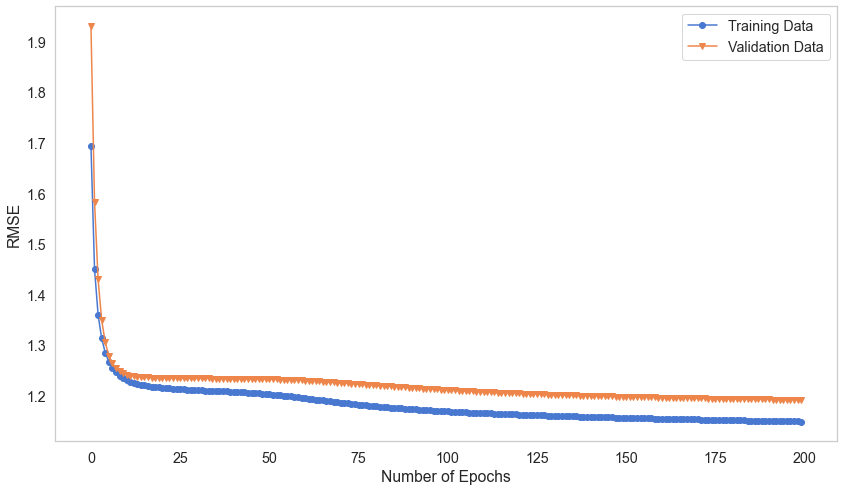

In [7]:
recommender = Recommender().fit(train, val)

plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

## Predict rating of user 53698 and input the predicted data into csv

In [16]:

user_id = 53698
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]

rating_predictions = recommender.predict(train, user_index)

def create_teleplay_ratings(teleplay_df, teleplay_index, ratings, n=9927):
    teleplay_ids = ratings_df.columns[teleplay_index]
    teleplay_ratings = pd.DataFrame(data=dict(teleplayId=teleplay_ids, rating=ratings))
    top_n_teleplay = teleplay_ratings.sort_values("rating", ascending=False).head(n)

    teleplay_recommendations = teleplay_df[teleplay_df.teleplay_id.isin(top_n_teleplay.teleplayId)].reset_index(drop=True)
    teleplay_recommendations['rating'] = pd.Series(top_n_teleplay.rating.values)
    
    #insert predicted data of user 53698 to csv
    task2_csv = teleplay_recommendations[['teleplay_id','rating']]
    print(task2_csv)
    task2_csv.to_csv('18063466D_task2.csv', index = False)
    
    return teleplay_recommendations.sort_values("rating", ascending=False)

create_teleplay_ratings(teleplay_data, predictions_index, rating_predictions)



      teleplay_id     rating
0           32281  10.364842
1           28977  10.093901
2            9969   9.306950
3           32935   9.253768
4           11061   9.251870
...           ...        ...
5835         5541   5.235418
5836         9316   5.234368
5837         5543   5.233844
5838         5621   5.232304
5839         6133   5.232227

[5840 rows x 2 columns]


,teleplay_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",long,1,10.364842,200630
1,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",medium,51,10.093901,114262
2,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",medium,51,9.306950,151266
3,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",medium,10,9.253768,93351
4,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",medium,148,9.251870,425855
...,...,...,...,...,...,...,...
5835,5541,The Satisfaction,Restricted,short,1,5.235418,166
5836,9316,Toushindai My Lover: Minami tai Mecha-Minami,Restricted,short,1,5.234368,211
5837,5543,Under World,Restricted,short,1,5.233844,183
5838,5621,Violence Gekiga David no Hoshi,Restricted,short,4,5.232304,219
